## Energy spectra and count estimation from my MC data (before processing)

### The original idea was trying to estimate an efficiency comparing the volumes energy spectra with the energy spectra of the isotope in the center of the detector, but the idea was not really good

In [1]:
import numpy as np
import os
import pandas as pd
import tables as tb
from glob import glob

import matplotlib.pyplot as plt
import invisible_cities.io.dst_io as dio

from matplotlib.patches import Patch


In [2]:
isotope = '214Bi'

In [3]:
path_full  = '/mnt/lustre/scratch/nlsas//home/usc/ie/mpm/NEXT100/data/full_prod/{}/prod/*/events_energy.h5'.format(isotope)
path_gamma = '/mnt/lustre/scratch/nlsas//home/usc/ie/mpm/NEXT100/data/full_prod/{}/prod/*/events_energy_clean.h5'.format(isotope)
st_path = '/mnt/lustre/scratch/nlsas//home/usc/ie/mpm/NEXT100/data/full_prod/{}/prod/event_stats.txt'.format(isotope)
act_path = '/home/usc/ie/mpm/NEXT100-0nubb-analysis/nexus_job_templates/ft3/backgrounds/activities_efficiencies_upd2.ods'
plot_path = '/mnt/lustre/scratch/nlsas//home/usc/ie/mpm/NEXT100/data/full_prod/{}/plots/'.format(isotope)

In [4]:
activities = dict(pd.read_excel(act_path, sheet_name=isotope, engine='odf').set_index("G4Volume").TotalActivity)
activities['CENTER'] = None

In [5]:
with open(st_path, 'r') as f:
    text = f.readlines()
    f.close()

In [6]:
sim_evs = {t.split(' ')[-4].split('/')[-1]:int(t.split(' ')[-2])*int(t.split(' ')[1]) for t in text}
sim_evs['CENTER'] = int(1e6)

In [7]:
full_path = sorted([p for p in glob(path_full)])
gamma_path = sorted([p for p in glob(path_gamma)])

bkg_full_path = sorted([p for p in glob(path_full) if p.split('/')[-2] != 'CENTER'])
act_full_path = sorted([p for p in glob(path_full) if p.split('/')[-2] == 'CENTER'])
bkg_gamma_path = sorted([p for p in glob(path_gamma) if p.split('/')[-2] != 'CENTER'])
act_gamma_path = sorted([p for p in glob(path_gamma) if p.split('/')[-2] == 'CENTER'])


In [8]:
def plot_hist(hist, bins, legend = ''):
    edges = bins[:-1].copy()
    freq  = hist.copy()
    diff  = np.diff(edges)[0]
    step_edges = np.append(np.append(edges[0], edges), edges[-1])
    step_freq  = np.append(np.append(0, freq), 0)
    plt.step(step_edges, step_freq, where = 'post', linewidth = 1, label = legend)

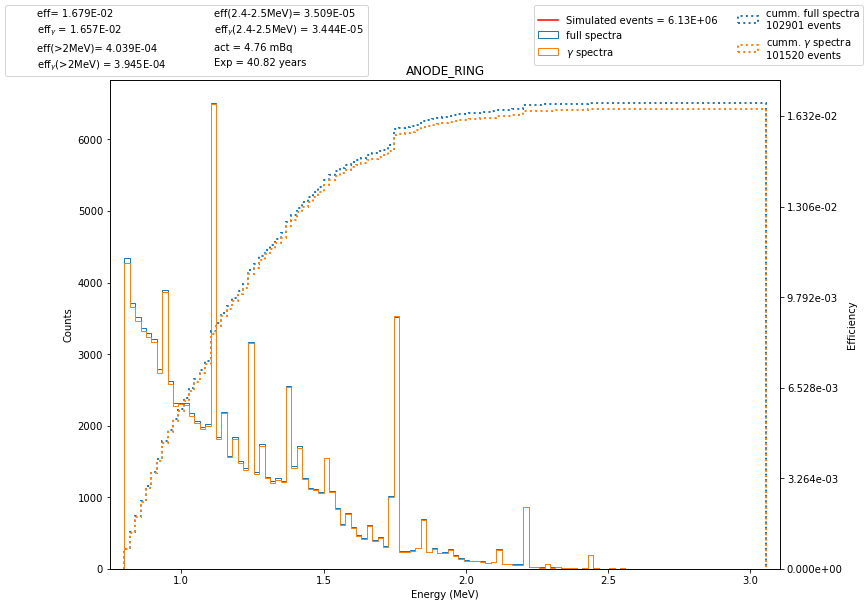

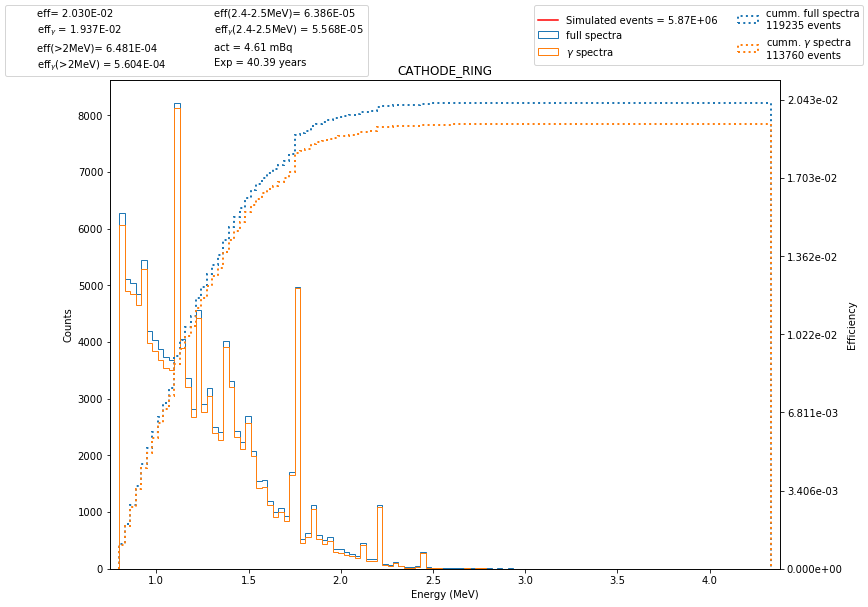

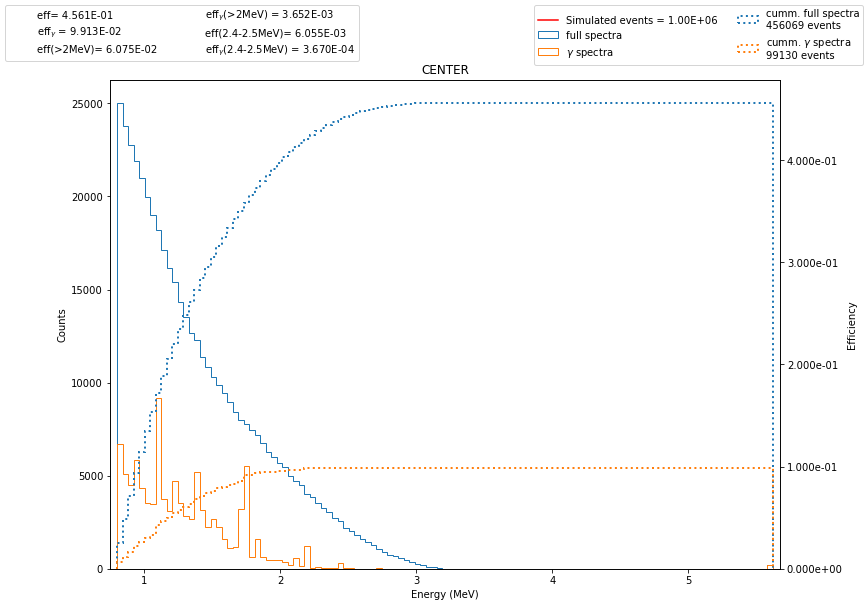

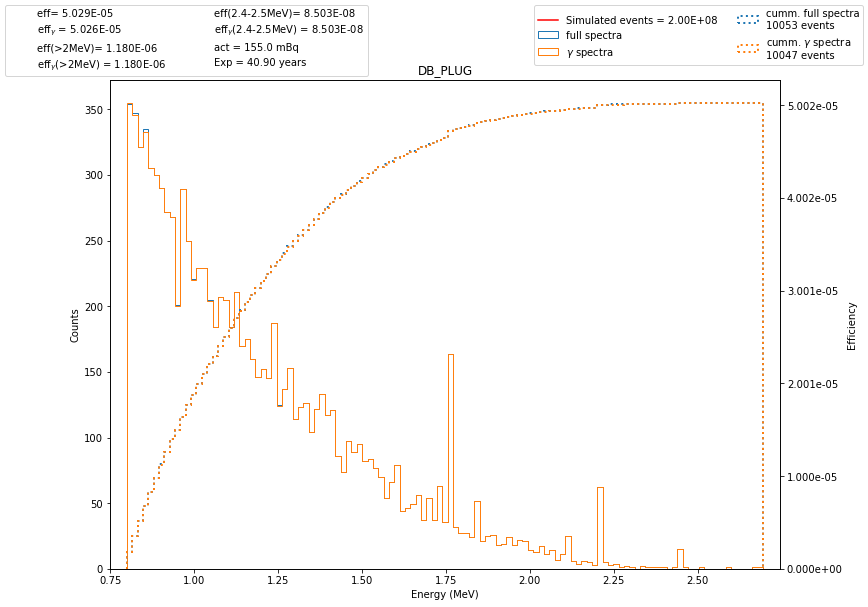

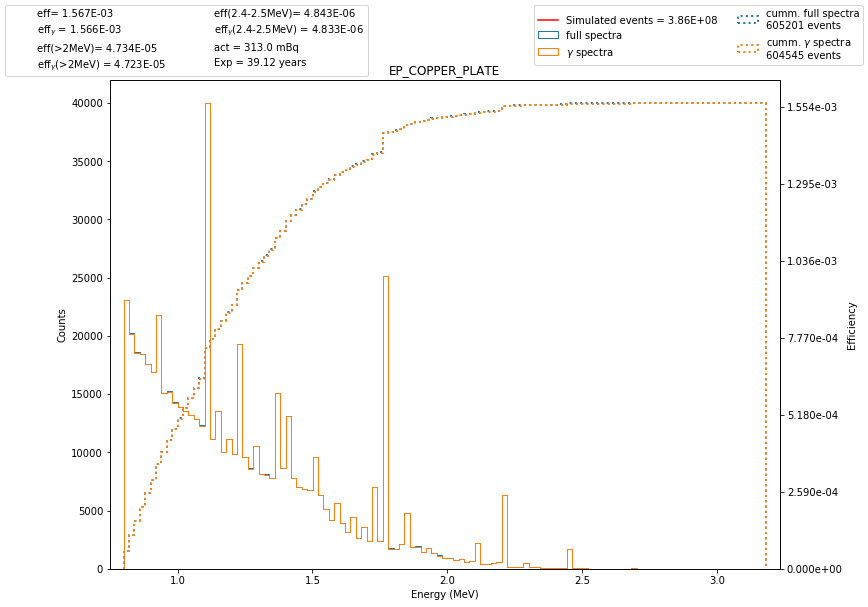

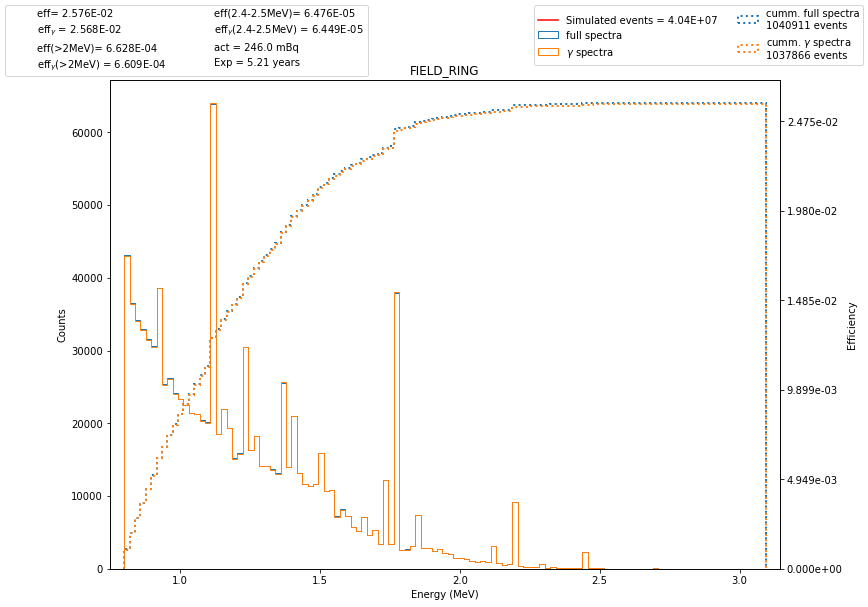

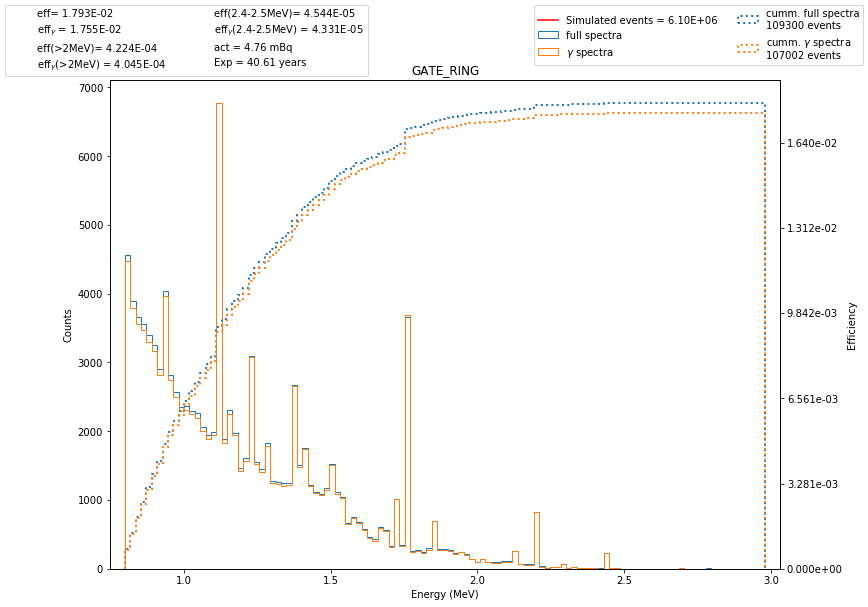

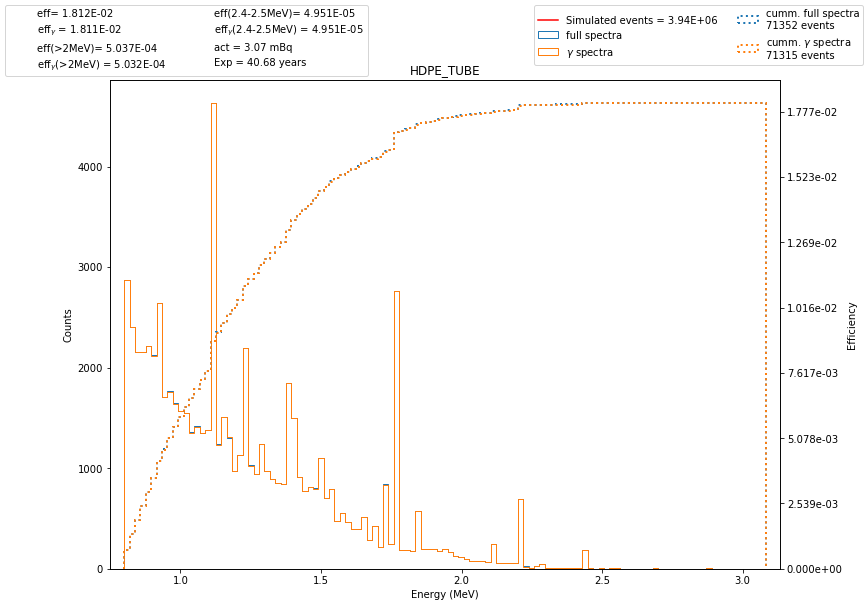

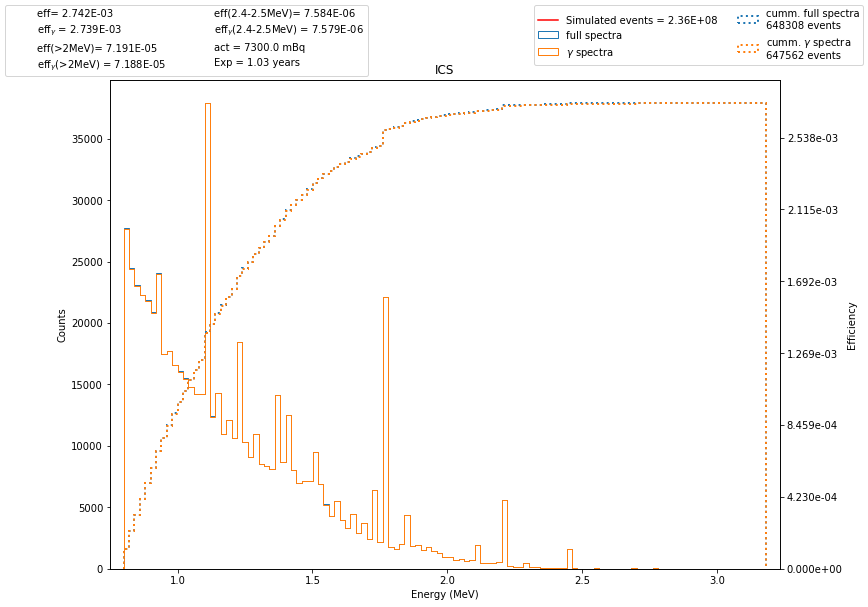

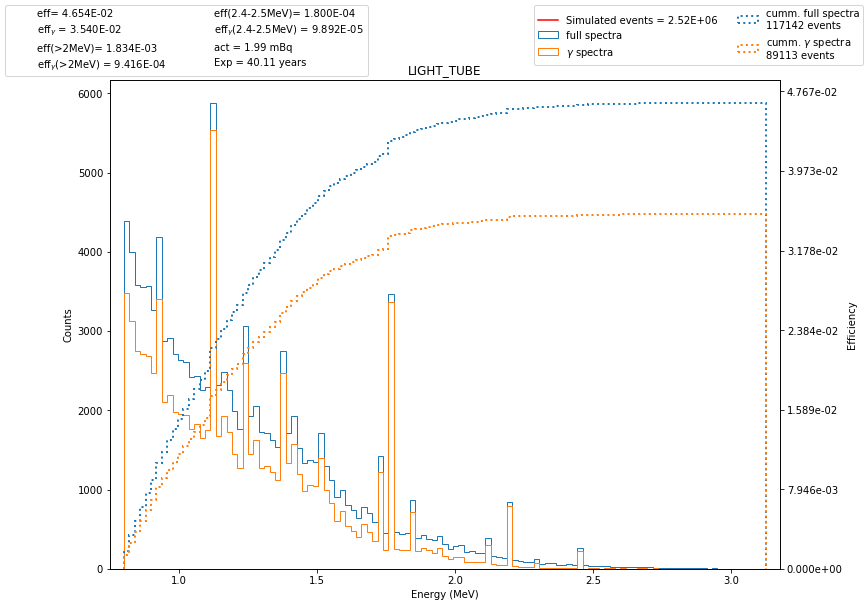

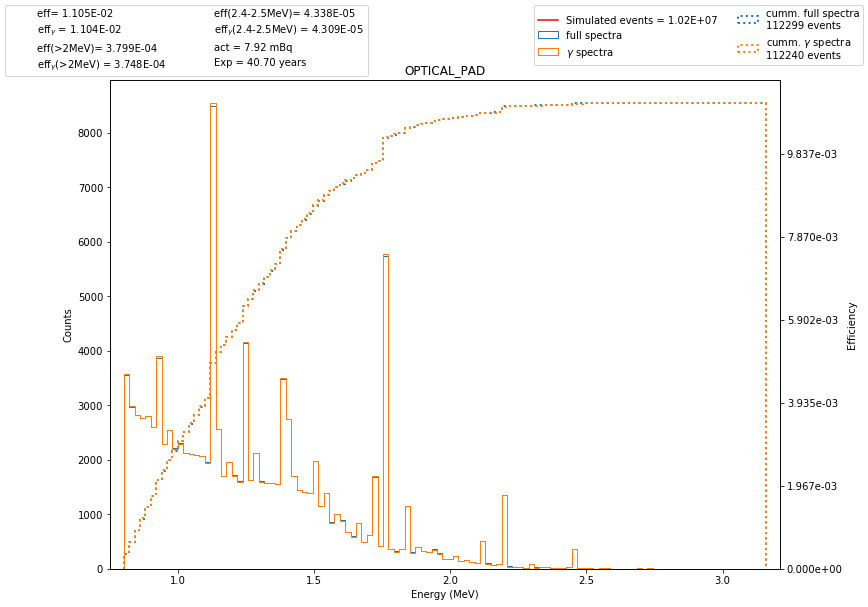

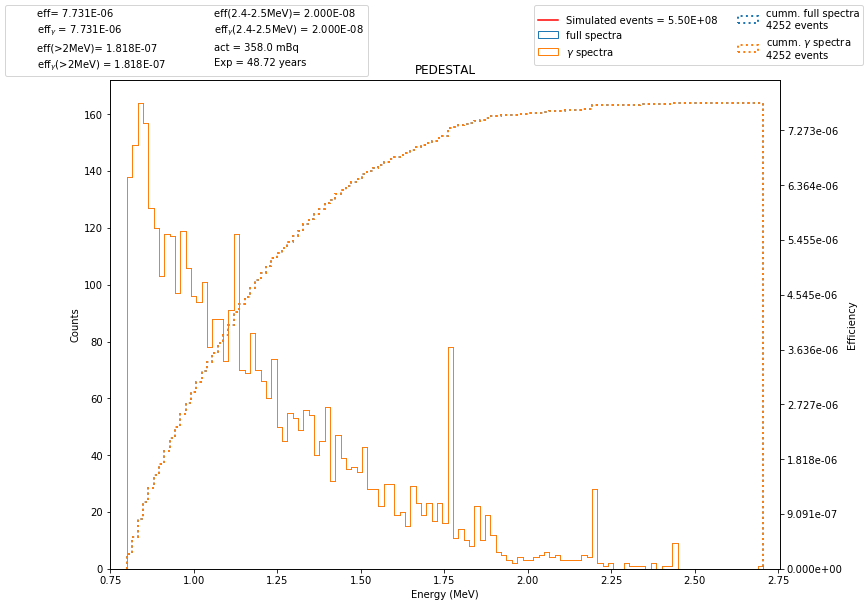

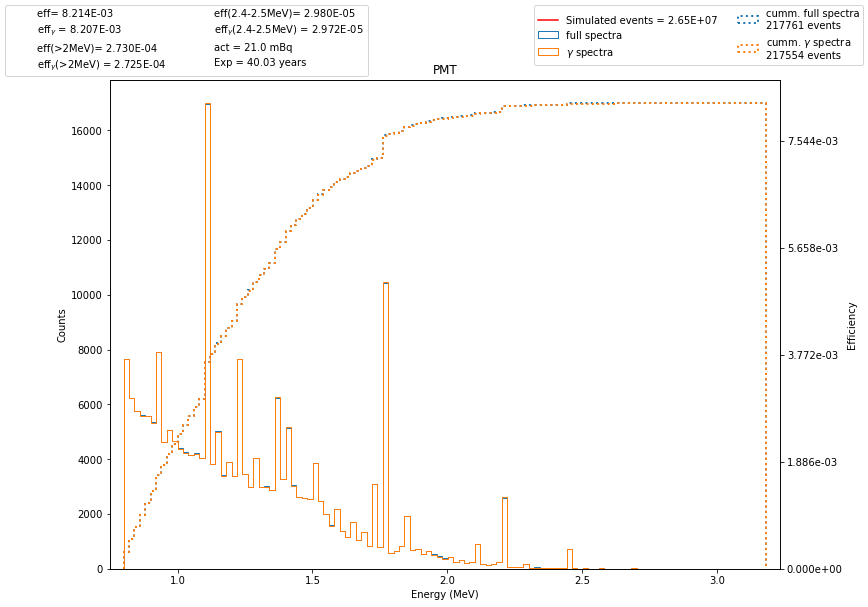

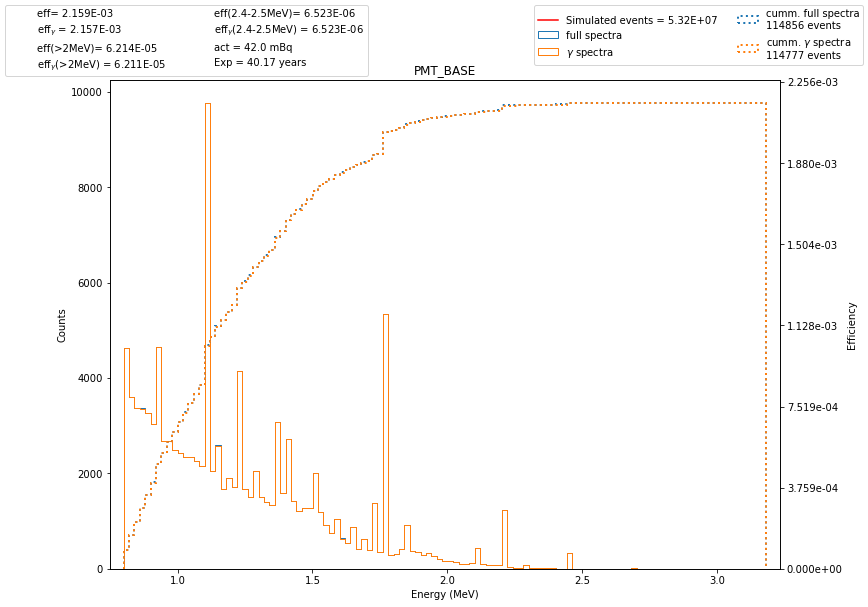

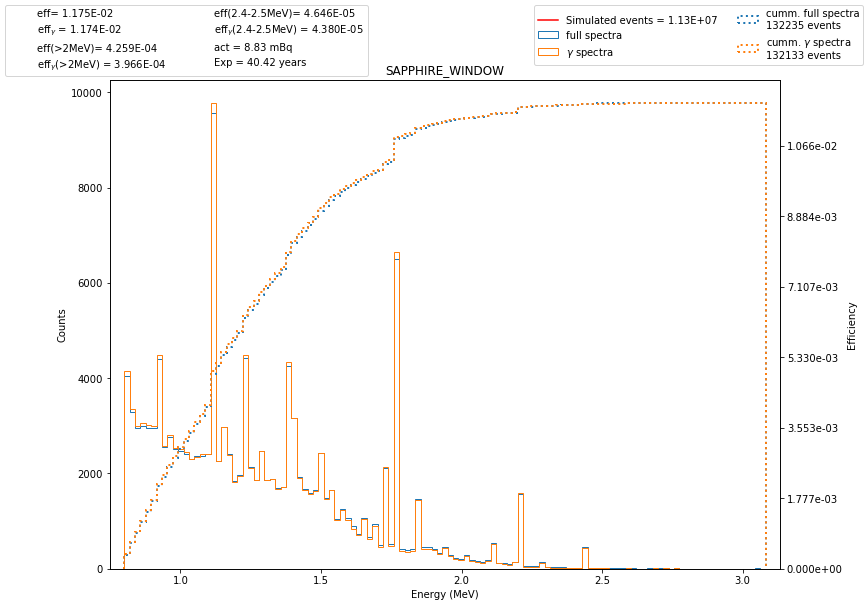

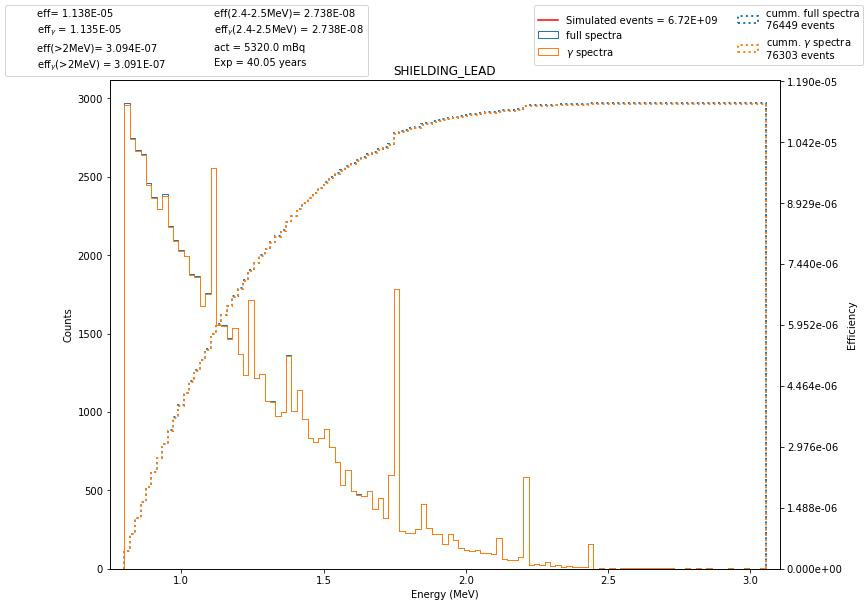

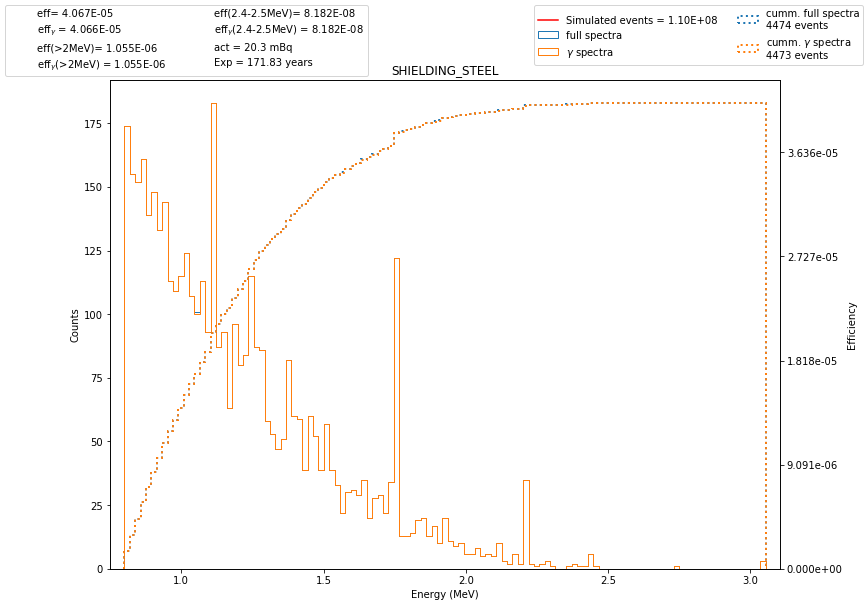

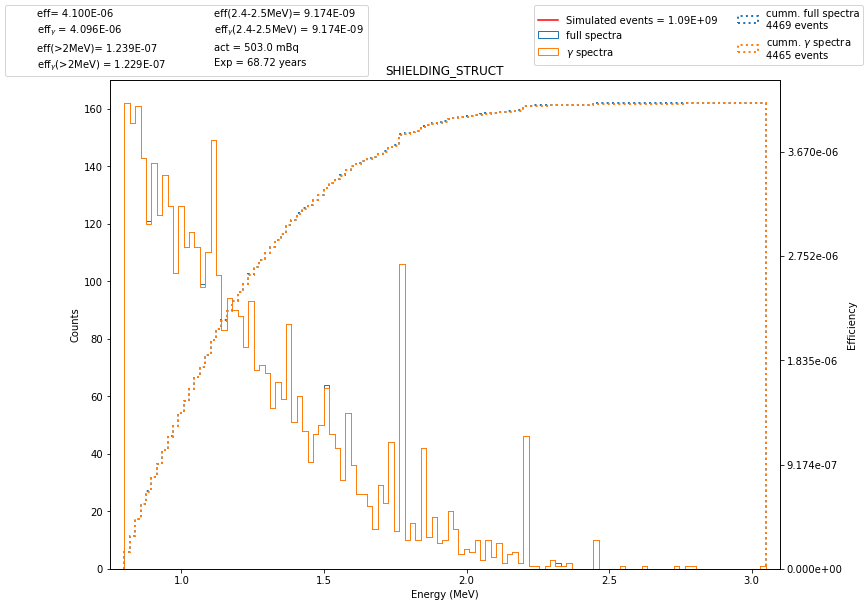

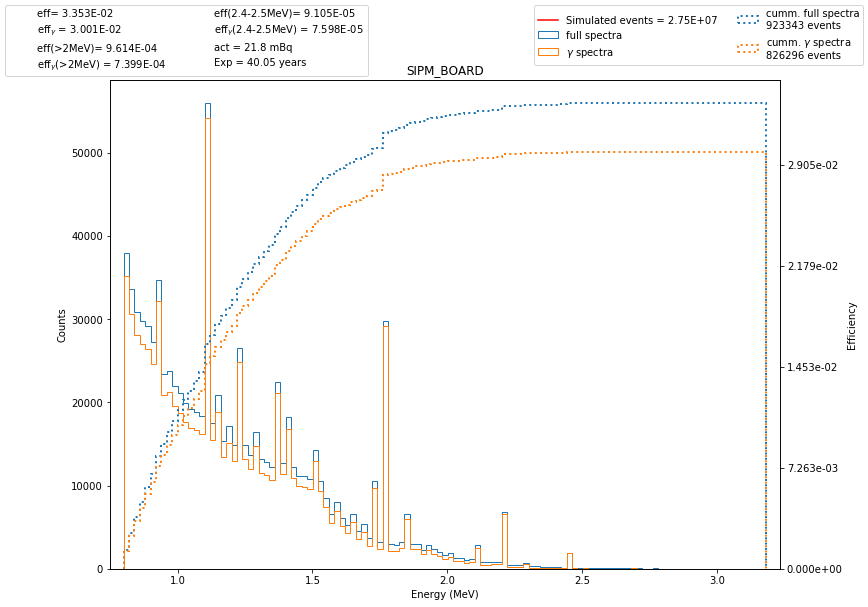

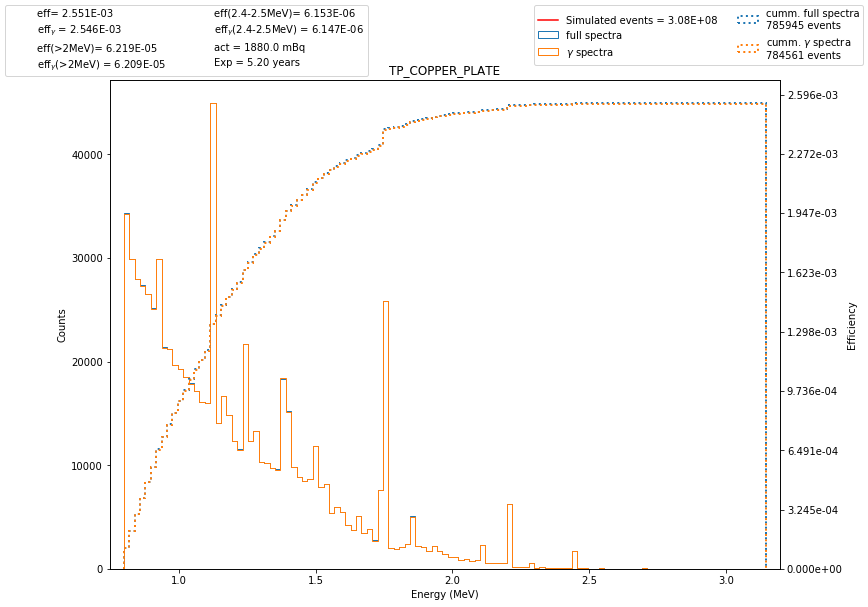

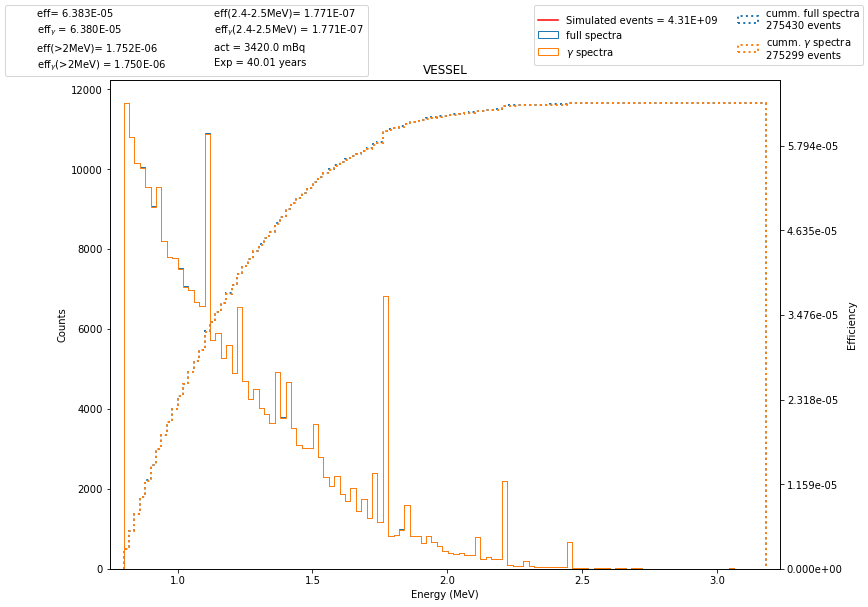

In [9]:
compute_range = False
simulation_min_ener = 0.8
min_counts_vol = 100

#for activities in mBq to year^-1
year = (3600 * 24 * 365) / 1000
info_list = []
for f, g in zip(full_path, gamma_path):
    vol = f.split('/')[-2]
    full_ev_ener = dio.load_dst(f, 'MC', 'EventEnergy')
    gamma_ev_ener = dio.load_dst(g, 'MC', 'EventEnergy')
    nbins = 119

    if compute_range:
        xrange = (min(full_ev_ener.energy.min(), gamma_ev_ener.energy.min()), max(full_ev_ener.energy.max(), gamma_ev_ener.energy.max()))
    else:
        xrange = (simulation_min_ener, max(full_ev_ener.energy.max(), gamma_ev_ener.energy.max()))
    
    #we limitate because after the clean there are values below 0.8 (min energy in the simulation)
    full_xrange_ene = full_ev_ener[(full_ev_ener.energy >= xrange[0]) & (full_ev_ener.energy <= xrange[1])]
    gamma_xrange_ene = gamma_ev_ener[(gamma_ev_ener.energy >= xrange[0]) & (gamma_ev_ener.energy <= xrange[1])]
    
    fig, ax1 = plt.subplots(figsize = (12, 9))
    ax1.plot([], [], 'r', label = 'Simulated events = {:.2E}'.format(sim_evs[vol]))

    ax1.set_xlabel('Energy (MeV)')
    ax1.set_ylabel('Counts')
    ax1.hist(full_xrange_ene.energy, bins = nbins, range = xrange, histtype='step', label = 'full spectra')
    ax1.hist(gamma_xrange_ene.energy, bins = nbins, range = xrange, histtype='step', label = r'$\gamma$ spectra')


    ax2 = ax1.twinx()
    ax2.set_ylabel('Efficiency')
    #JA told me that the cummulative histogram is done for all the spectrum, not the range I selected
    #but in this way, there is no difference between both eff (full and gamma spectra)
    #to change for doing all the spectra for the cumm hist, change the _xrange_ene for _ev_ener (also in the legend) and delete the range = xrange
    ax2.hist(full_xrange_ene.energy, bins = nbins, range = xrange, histtype='step', ls=':', lw = 2, cumulative = True, label = 'cumm. full spectra\n{} events'.format(len(full_xrange_ene)) )
    ax2.hist(gamma_xrange_ene.energy, bins = nbins, range = xrange, histtype='step', ls=':', lw = 2, cumulative = True, label = r'cumm. $\gamma$ spectra' + '\n{} events'.format(len(gamma_xrange_ene)))
    ax2.set_xlim((xrange[0] - 0.05, xrange[1] + 0.05))
    ax1.set_title(vol)
    fig.suptitle('')

    eff = len(full_xrange_ene) / sim_evs[vol]
    eff_gamma = len(gamma_xrange_ene) / sim_evs[vol]
    nroi = len(full_xrange_ene[(full_xrange_ene.energy >= 2.4) & (full_xrange_ene.energy <= 2.5)])
    nroi_gamma = len(gamma_xrange_ene[(gamma_xrange_ene.energy >= 2.4) & (gamma_xrange_ene.energy <= 2.5)])
    hand = [Patch(facecolor='white', edgecolor='white', label='eff= {:.3E}'.format(eff)),
            Patch(facecolor='white', edgecolor='white', label=r'eff$_{\gamma}$ = ' + '{:.3E}'.format(eff_gamma)),
            Patch(facecolor='white', edgecolor='white', label='eff(>2MeV)= {:.3E}'.format(len(full_xrange_ene[full_xrange_ene.energy >= 2]) / sim_evs[vol])),
            Patch(facecolor='white', edgecolor='white', label=r'eff$_{\gamma}$(>2MeV) = ' + '{:.3E}'.format(len(gamma_xrange_ene[gamma_xrange_ene.energy >= 2]) / sim_evs[vol])), 
            Patch(facecolor='white', edgecolor='white', label='eff(2.4-2.5MeV)= {:.3E}'.format( nroi / sim_evs[vol])),
            Patch(facecolor='white', edgecolor='white', label=r'eff$_{\gamma}$(2.4-2.5MeV) = ' + '{:.3E}'.format( nroi_gamma / sim_evs[vol]))]
    
    if vol != 'CENTER':
        hand.append(Patch(facecolor='white', edgecolor='white', label='act = {} mBq'.format(activities[vol])))
        #the exposure for the final saved counts, not for the numer of simulated events (that doesn't make sense)
        #it would be the len of the xrange ene events / (act * year * eff), which would cancell the number of saved events with the
        #specific efficiency, and only will be left the number of sim events / (act * year)
        hand.append(Patch(facecolor='white', edgecolor='white', label='Exp = {:.2f} years'.format(sim_evs[vol] / (activities[vol] * year ))))

    ax2.set_yticklabels(['{:.3e}'.format(x / sim_evs[vol]) for x in ax2.get_yticks().tolist()])
    fig.legend(handles = hand, loc = 'upper left', ncol = 2)
    fig.legend(ncol = 2)
    #plt.savefig(plot_path + '{}_{}.png'.format(isotope, vol))
    plt.show()
    info_dict = {'vol':vol, 
                 'nsim':sim_evs[vol], 
                 'nrange':len(full_xrange_ene), 
                 'nrange_gamma':len(gamma_xrange_ene), 
                 'nroi':nroi, 
                 'nroi_gamma':nroi_gamma}
    info_list.append(info_dict)
info_df = pd.DataFrame(info_list)

In the info_dict now we have the information per volume of the number of simulated events, the number of MC events in a energy range (with and without the clean spectra) and the number of MC events in the ROI of 2.4 - 2.5 MeV.

From Gonzalo's thesis I'm picking the factor that he found after processing and performing data cuts in order to have a sense of what would happen with this production without processing it all

In [10]:
if isotope == '214Bi':
    roi_sel_factor = 4.9 / 296
    topo_sel_factor = 0.45 / 296
elif isotope == '208Tl':
    roi_sel_factor = 5.2 / 1800
    topo_sel_factor = 0.47 / 1800
else:
    print('No valid isotope')

With this factor multiplied by the events in the ROI we could estimate the number of counts after the processing.

In [11]:
info_df['nroi_sel'] = info_df.nroi * roi_sel_factor
info_df['nroi_topo'] = info_df.nroi * topo_sel_factor

In [14]:
info_df[info_df.vol != 'CENTER'][['vol', 'nsim', 'nrange', 'nroi', 'nroi_sel', 'nroi_topo']]

,vol,nsim,nrange,nroi,nroi_sel,nroi_topo
0,ANODE_RING,6127152,102901,215,3.559122,0.326858
1,CATHODE_RING,5872545,119235,375,6.207770,0.570101
3,DB_PLUG,199920050,10053,17,0.281419,0.025845
4,EP_COPPER_PLATE,386100000,605201,1870,30.956081,2.842905
5,FIELD_RING,40409712,1040911,2617,43.321959,3.978547
6,GATE_RING,6096272,109300,277,4.585473,0.421115
7,HDPE_TUBE,3938760,71352,195,3.228041,0.296453
8,ICS,236432040,648308,1793,29.681419,2.725845
9,LIGHT_TUBE,2517076,117142,453,7.498986,0.688682
10,OPTICAL_PAD,10165771,112299,441,7.300338,0.670439


The main difference between center and the volumes is that:
* For center there will be always betas and sometimes the gamma escapes, sometimes the gamma interacts in the active. So, when cleaning the spectra from the betas, those events that had a gamma escaping (a lot of them) will have energy 0. That's why the cummulative for the gamma starts with a very high value at 0.8 MeV and also why both full and gamma cummulative end with the same number. Also, the reason for not having all the simulated events detected is because all of the events below 0.8 MeV in the nexus simulation were cut off.
* For the volumes, betas mainly vanish before reaching the active, therefore the detected events are the gammas that reached the active and interacted there. So, when I clean the spectra from the betas, first we will probably not see a big difference unless the volume is close to the active region. Also, in this volumes appear a lot of events where the betas entered the active but the gammas scaped, so for the gamma spectra appear events with energy 0.

ANODE_RING ===> 3.443688029936257e-05
CATHODE_RING ===> 5.5682842787922444e-05
DB_PLUG ===> 8.503399233843728e-08
EP_COPPER_PLATE ===> 4.832944832944833e-06
FIELD_RING ===> 6.448944748727732e-05
GATE_RING ===> 4.330515436319114e-05
HDPE_TUBE ===> 4.9507966974377725e-05
ICS ===> 7.579344999095723e-06
LIGHT_TUBE ===> 9.892430741066221e-05
OPTICAL_PAD ===> 4.30857629982025e-05
PEDESTAL ===> 2e-08
PMT ===> 2.9724772372559284e-05
PMT_BASE ===> 6.5225563909774434e-06
SAPPHIRE_WINDOW ===> 4.379687064696418e-05
SHIELDING_LEAD ===> 2.738095238095238e-08
SHIELDING_STEEL ===> 8.181818181818182e-08
SHIELDING_STRUCT ===> 9.174311926605505e-09
SIPM_BOARD ===> 7.597602498812239e-05
TP_COPPER_PLATE ===> 6.146528833840568e-06
VESSEL ===> 1.7706617832840618e-07


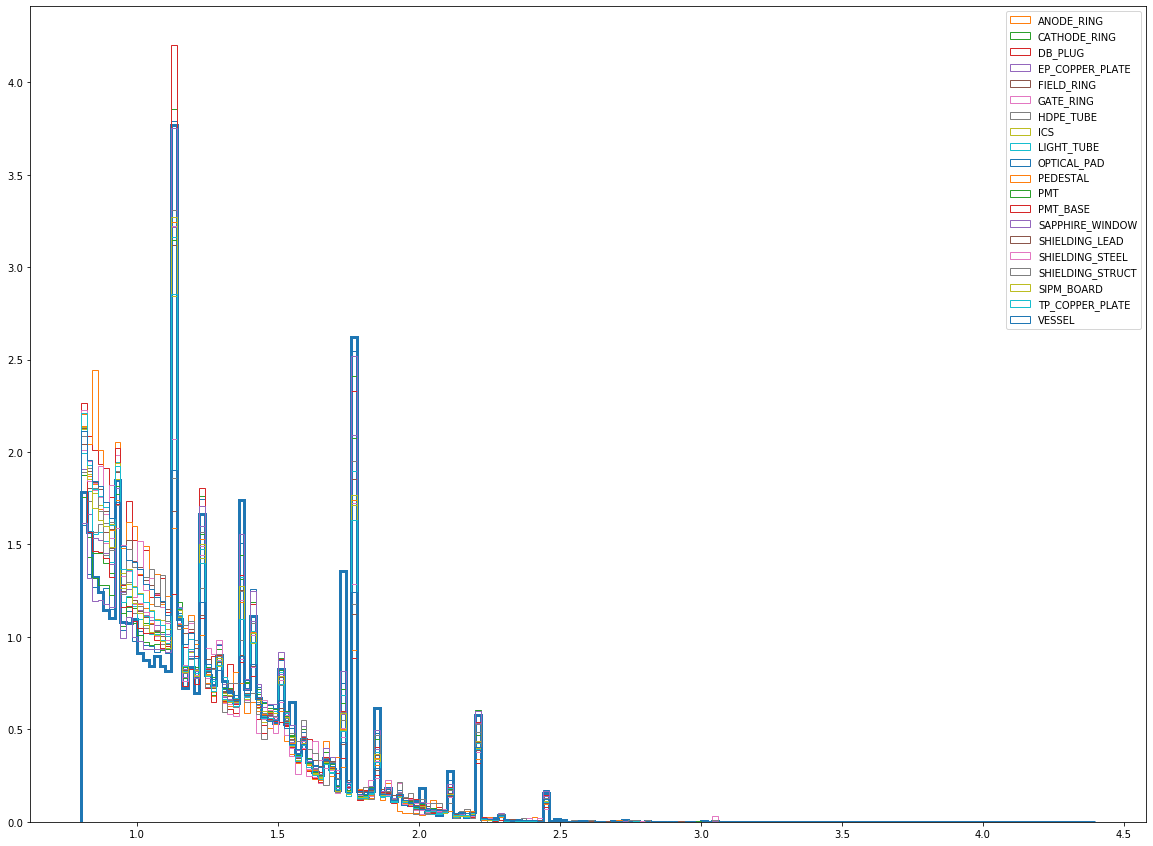

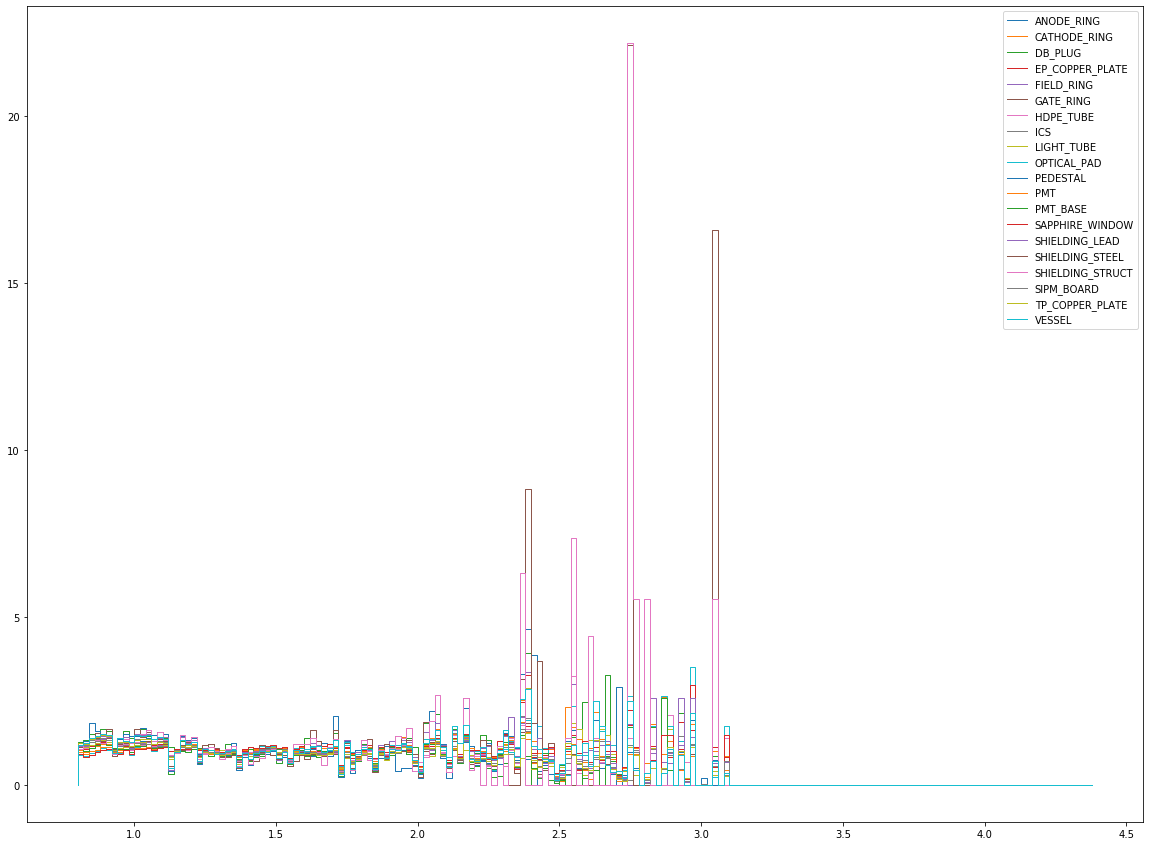

In [49]:
xmin = 0.8 #0 #0.8000003099441528 #
xmax = 4.4 #4.33076810836792 #
nbins = 180 #119

bkg_ev_ener = pd.DataFrame([])
#cen_ev_ener = dio.load_dst(act_path[0], 'MC', 'EventEnergy')
cen_ev_ener = dio.load_dst(act_gamma_path[0], 'MC', 'EventEnergy')
plt.figure(1, figsize=(20, 15))
center_hist = plt.hist(cen_ev_ener.energy, bins = nbins, range = (xmin, xmax), density = True, histtype='step', lw = 3)
#center_count_hist = plt.hist(cen_ev_ener.energy, bins = 119, range = (xmin, xmax), density = False, histtype='step', lw = 2)
cen_eff = len(cen_ev_ener) / 1e6
for p in bkg_gamma_path:
    volume = p.split('/')[-2]
    ener = dio.load_dst(p, 'MC', 'EventEnergy')
    
    vol_eff = len(ener) / sim_evs[volume]
    #print(volume, '====>', vol_eff)
    #Este calculo deberia equivaler a el nsaved/nsim de gonzalo... porque al final lo que tenemos de nexus es
    #solo
    print(volume, '===>', len(ener[(ener.energy > 2.4) & (ener.energy < 2.5)]) / sim_evs[volume])
    plt.figure(1, figsize=(20, 15))
    vol_hist = plt.hist(ener.energy, bins = nbins, range = (xmin, xmax), density = True, histtype='step', label = volume)
    plt.legend()

    plt.figure(2, figsize=(20, 15))
    eff_hist = np.divide(vol_hist[0], center_hist[0], out=np.zeros_like(vol_hist[0]), where=center_hist[0]!=0)
    plot_hist(eff_hist, vol_hist[1], legend=volume)
    plt.legend()

    #prueba a ver entre 2.4 y 2.5 MeV que numeros salen
    #print(volume, '====>', "{:.2E}".format(sum(eff_hist[80:85] * np.diff(vol_hist[1])[0]) * vol_eff))
    
    #count_eff = np.divide(vol_count_hist[0], center_count_hist[0], out=np.zeros_like(vol_count_hist[0]), where=center_count_hist[0]!=0)
    #print(eff_hist.sum() * (vol_hist[1][1] - vol_hist[1][0]) * cen_eff * vol_eff)
    #print(count_eff.sum() * len(cen_ev_ener) * len(cen_ev_ener) * (vol_hist[1][1] - vol_hist[1][0]) / (sim_evs[volume] * 1e6))
    #plt.show()

    bkg_ev_ener = bkg_ev_ener.append(ener)
